# 2: Explicit ODE Solver

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint
from TestProblems import prey_predator_model, van_der_pol_model, CSTR_3state_model, CSTR_1state_model
from Solvers import ExplicitEulerFixedSteps, ExplicitEulerAdaptiveStep, ImplicitEulerFixedStep

## Stability plot for the Explicit Euler method

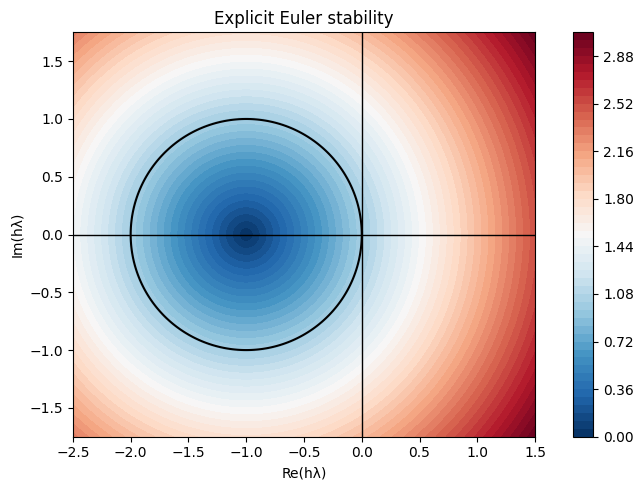

In [2]:
# Create grid in the complex plane
x = np.linspace(-2.5, 1.5, 400)
y = np.linspace(-1.75, 1.75, 400)
X, Y = np.meshgrid(x, y)
Z = X + 1j * Y

# Amplification factor for Explicit Euler: R(z) = 1 + z
R = 1 + Z
R_mag = np.abs(R)

# Plot
plt.figure(figsize=(8, 5))
cp = plt.contourf(X, Y, R_mag, levels=50, cmap="RdBu_r")
cbar = plt.colorbar(cp)

# Add the stability boundary: |R(z)| = 1
plt.contour(X, Y, R_mag, levels=[1], colors='black')

# Axis formatting
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.title("Explicit Euler stability")
plt.xlabel("Re(hλ)")
plt.ylabel("Im(hλ)")
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()


## Test algorithms on test problems

### Prey-predator problem

#### Explicit Euler fixed step size = 0.1

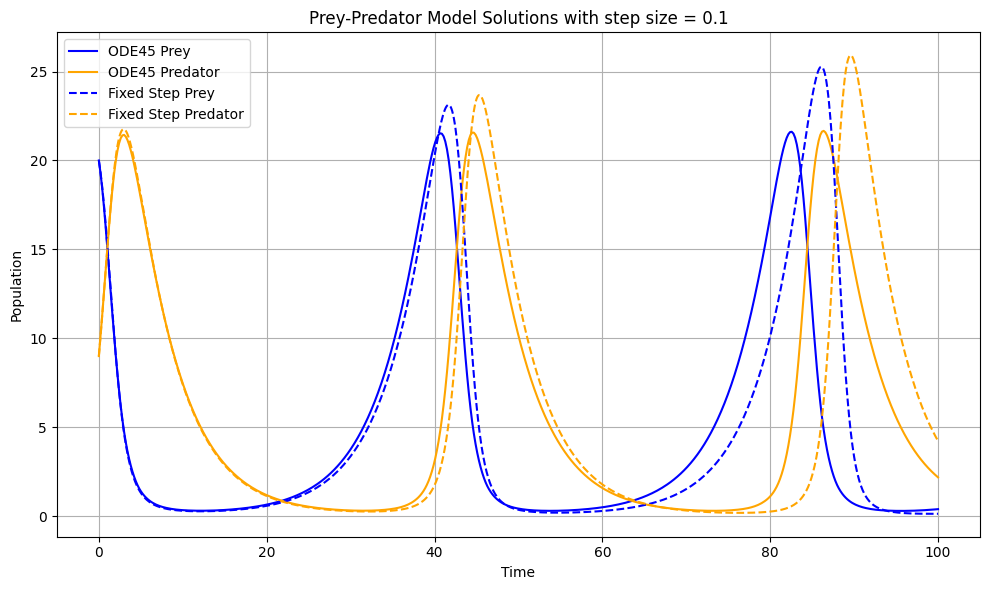

In [3]:
# Define time span and initial conditions
t_span = (0, 100)
x0 = np.array([20, 9])  # Example initial conditions for prey and predator populations
a = 0.2  # Prey growth rate
b = 0.04  # Predation rate

f, J = prey_predator_model(a, b)

# Solve using ode45 (method='RK45')
solution_ode45 = solve_ivp(f, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], 500))

# Solve using Explicit Euler with fixed step size
N = 1000
solution_fixed_t, solution_fixed_x = ExplicitEulerFixedSteps(f, t_span[0], t_span[1], N, x0)


# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(solution_ode45.t, solution_ode45.y[0], label='ODE45 Prey', color='blue')
plt.plot(solution_ode45.t, solution_ode45.y[1], label='ODE45 Predator', color='orange')
plt.plot(solution_fixed_t, solution_fixed_x[0], label='Fixed Step Prey', linestyle='--', color='blue')
plt.plot(solution_fixed_t, solution_fixed_x[1], label='Fixed Step Predator', linestyle='--', color='orange')
plt.title('Prey-Predator Model Solutions with step size = 0.1')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Explicit Euler fixed step size = 0.01

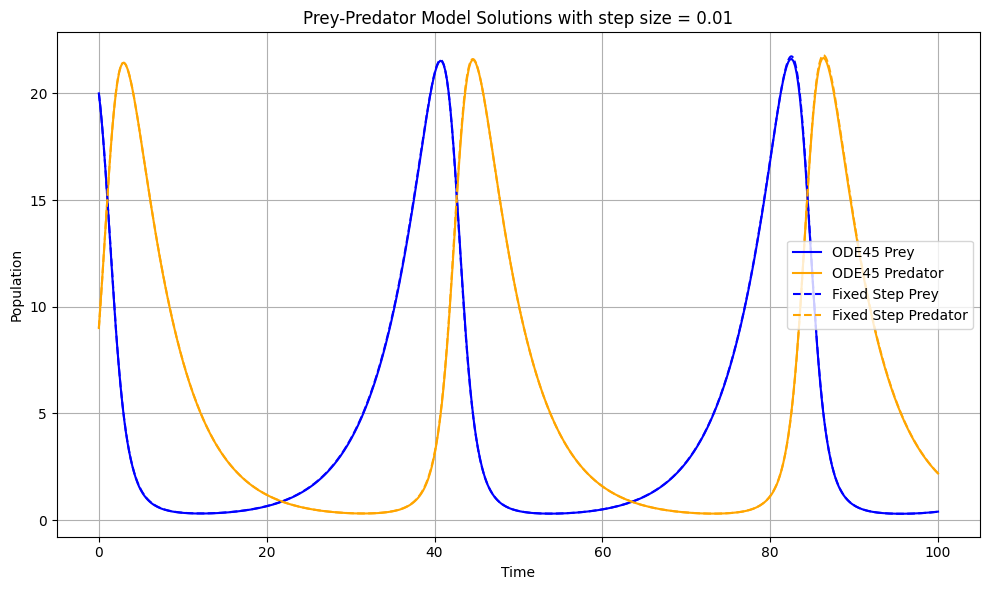

In [4]:
# Define time span and initial conditions
t_span = (0, 100)
x0 = np.array([20, 9])  # Example initial conditions for prey and predator populations
a = 0.2  # Prey growth rate
b = 0.04  # Predation rate

f, J = prey_predator_model(a, b)

# Solve using ode45 (method='RK45')
solution_ode45 = solve_ivp(f, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], 500))

# Solve using Explicit Euler with fixed step size
N = 10000
solution_fixed_t, solution_fixed_x = ExplicitEulerFixedSteps(f, t_span[0], t_span[1], N, x0)


# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(solution_ode45.t, solution_ode45.y[0], label='ODE45 Prey', color='blue')
plt.plot(solution_ode45.t, solution_ode45.y[1], label='ODE45 Predator', color='orange')
plt.plot(solution_fixed_t, solution_fixed_x[0], label='Fixed Step Prey', linestyle='--', color='blue')
plt.plot(solution_fixed_t, solution_fixed_x[1], label='Fixed Step Predator', linestyle='--', color='orange')
plt.title('Prey-Predator Model Solutions with step size = 0.01')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Explicit Euler with adaptive step size code

In [16]:
# Explicit Euler with adaptive step size
def ExplicitEulerAdaptiveStep(f, tspan, x0, h0, abstol, reltol, *args):
    # Initialize variables
    t0 = tspan[0]
    tf = tspan[1]
    # Initial conditions
    t = t0
    x = x0
    h = h0

    hmin = 0.1
    hmax = 5
    epstol = 0.8

    # Initialize output arrays
    T = [t0]
    X = [x0]
    H = [h0]

    # Main loop
    while t < tf:
        # Adjust step size
        if t + h > tf:
            h = tf - t

        fun = np.array(f(t, x))

        AcceptStep = False
        while not AcceptStep:
            # Compute the next step
            xnew = x + h * fun

            hm = 0.5 * h
            tm = t + hm
            xm = x + hm * fun
            xnewm = xm + hm * f(tm, xm)

            # Compute the error
            err = np.abs(xnewm - xnew)
            max1 = np.maximum(abstol, np.abs(xnewm) * reltol)
            r = np.max(err / max1)
            AcceptStep = (r <= 1)

            # Check if error is within tolerance
            if AcceptStep:
                # Update time and state
                t = t + h
                x = xnewm
                # Store values
                T.append(t)
                X.append(x)

            # Update step size
            h = np.max([hmin, np.min([hmax, np.sqrt(epstol / r)])]) * h
            H.append(h)

    return np.array(T), np.array(X), np.array(H)

#### Explicit Euler with adaptive step size with tolerance 10^-6

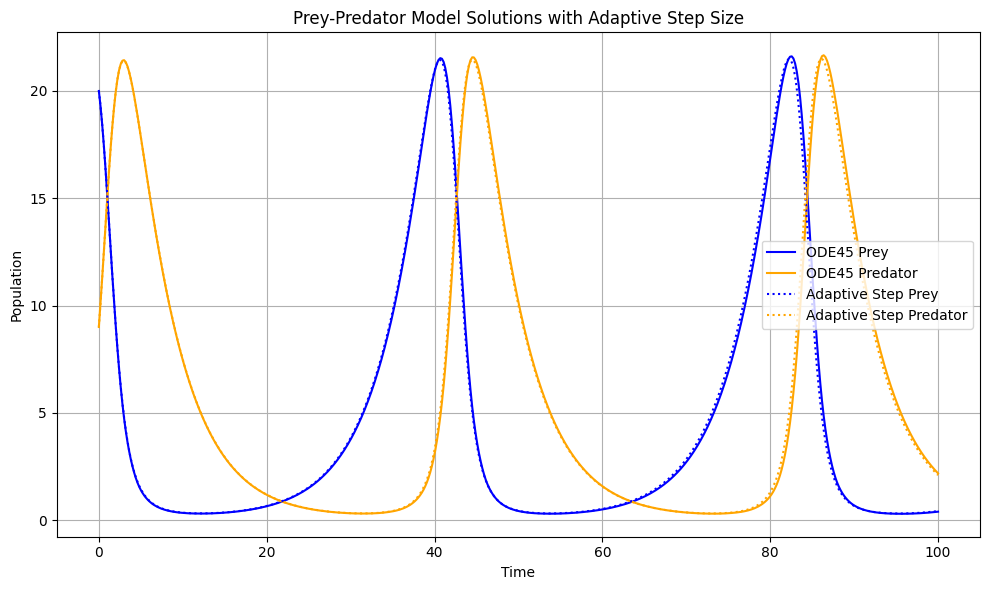

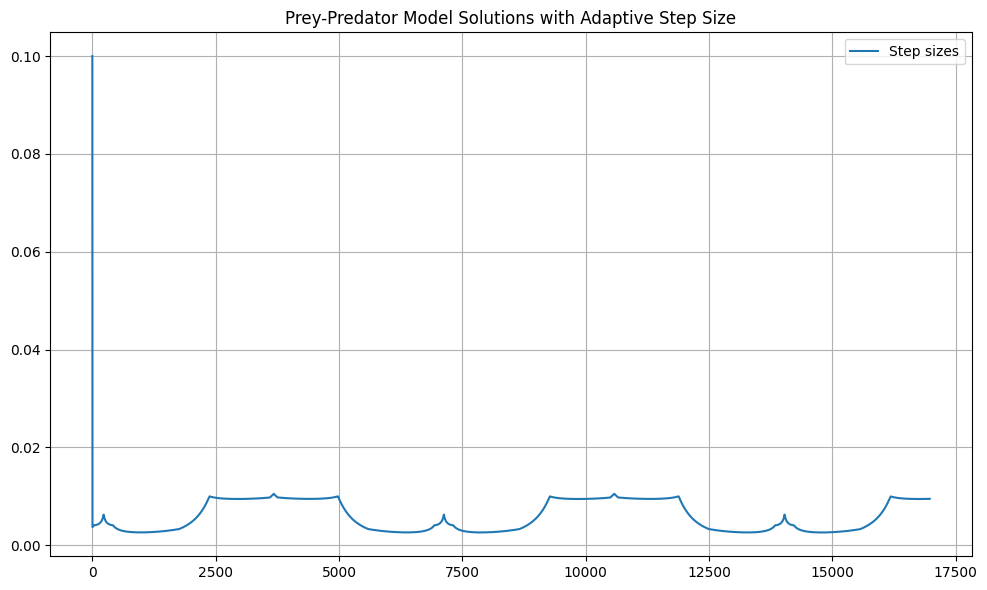

In [31]:
# Define time span and initial conditions
t_span = (0, 100)
x0 = np.array([20, 9])  # Example initial conditions for prey and predator populations
a = 0.2  # Prey growth rate
b = 0.04  # Predation rate

f, J = prey_predator_model(a, b)
# Solve using Explicit Euler with adaptive step size
h0 = 0.1

abs_tol = 1e-6
rel_tol = 1e-6

solution_adaptive_t, solution_adaptive_x, solution_adaptive_h = ExplicitEulerAdaptiveStep(f, t_span, x0, h0, abs_tol, rel_tol)

#Plot the results
plt.figure(figsize=(10, 6))
plt.plot(solution_ode45.t, solution_ode45.y[0], label='ODE45 Prey', color='blue')
plt.plot(solution_ode45.t, solution_ode45.y[1], label='ODE45 Predator', color='orange')
plt.plot(solution_adaptive_t, solution_adaptive_x[:, 0], label='Adaptive Step Prey', linestyle=':', color='blue')
plt.plot(solution_adaptive_t, solution_adaptive_x[:, 1], label='Adaptive Step Predator', linestyle=':', color='orange')
plt.title('Prey-Predator Model Solutions with Adaptive Step Size')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#Plot the stepsizes in solution_adaptive_h
plt.figure(figsize=(10, 6))
plt.plot(solution_adaptive_h, label = 'Step sizes')
plt.title('Prey-Predator Model Solutions with Adaptive Step Size')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()



#### Explicit Euler with adaptive step size with tolerance 10^-3

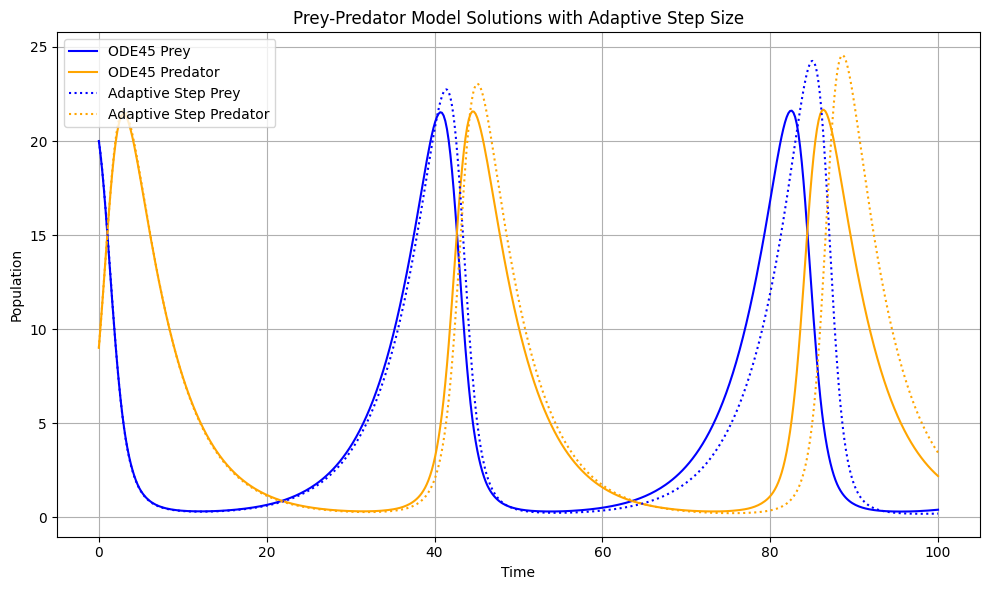

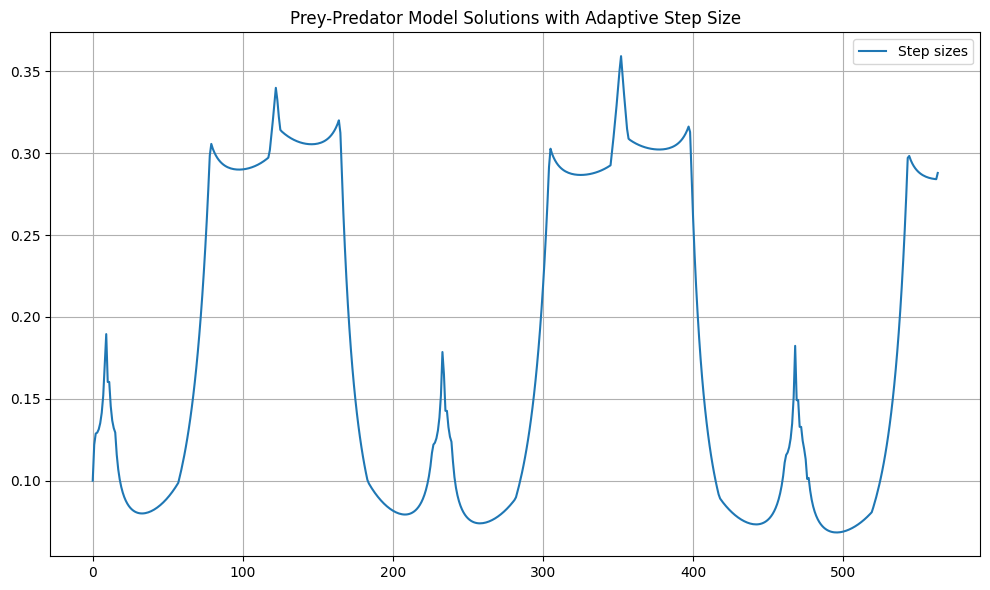

In [32]:
# Define time span and initial conditions
t_span = (0, 100)
x0 = np.array([20, 9])  # Example initial conditions for prey and predator populations
a = 0.2  # Prey growth rate
b = 0.04  # Predation rate

f, J = prey_predator_model(a, b)
# Solve using Explicit Euler with adaptive step size
h0 = 0.1

abs_tol = 1e-3
rel_tol = 1e-3

solution_adaptive_t, solution_adaptive_x, solution_adaptive_h = ExplicitEulerAdaptiveStep(f, t_span, x0, h0, abs_tol, rel_tol)

#Plot the results
plt.figure(figsize=(10, 6))
plt.plot(solution_ode45.t, solution_ode45.y[0], label='ODE45 Prey', color='blue')
plt.plot(solution_ode45.t, solution_ode45.y[1], label='ODE45 Predator', color='orange')
plt.plot(solution_adaptive_t, solution_adaptive_x[:, 0], label='Adaptive Step Prey', linestyle=':', color='blue')
plt.plot(solution_adaptive_t, solution_adaptive_x[:, 1], label='Adaptive Step Predator', linestyle=':', color='orange')
plt.title('Prey-Predator Model Solutions with Adaptive Step Size')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


#Plot the stepsizes in solution_adaptive_h
plt.figure(figsize=(10, 6))
plt.plot(solution_adaptive_h, label = 'Step sizes')
plt.title('Prey-Predator Model Solutions with Adaptive Step Size')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### Van der Pol problem

#### Explicit Euler with fixed step size = 0.1

In [56]:
20/200

0.1

/Users/katrine/Library/CloudStorage/OneDrive-Personligt/Kandidat/3rdSemester/Scientific Computing/Exam project/CodeandStuff/TestProblems.py:28: RuntimeWarning: overflow encountered in scalar multiply
  dydt = mu * (1 - x**2) * y - x
/Users/katrine/Library/CloudStorage/OneDrive-Personligt/Kandidat/3rdSemester/Scientific Computing/Exam project/CodeandStuff/TestProblems.py:28: RuntimeWarning: overflow encountered in scalar power
  dydt = mu * (1 - x**2) * y - x
/Users/katrine/Library/CloudStorage/OneDrive-Personligt/Kandidat/3rdSemester/Scientific Computing/Exam project/CodeandStuff/Solvers.py:20: RuntimeWarning: invalid value encountered in add
  X[:,k] = X[:,k-1] + dt*fun(T[k-1], X[:,k-1], *args)


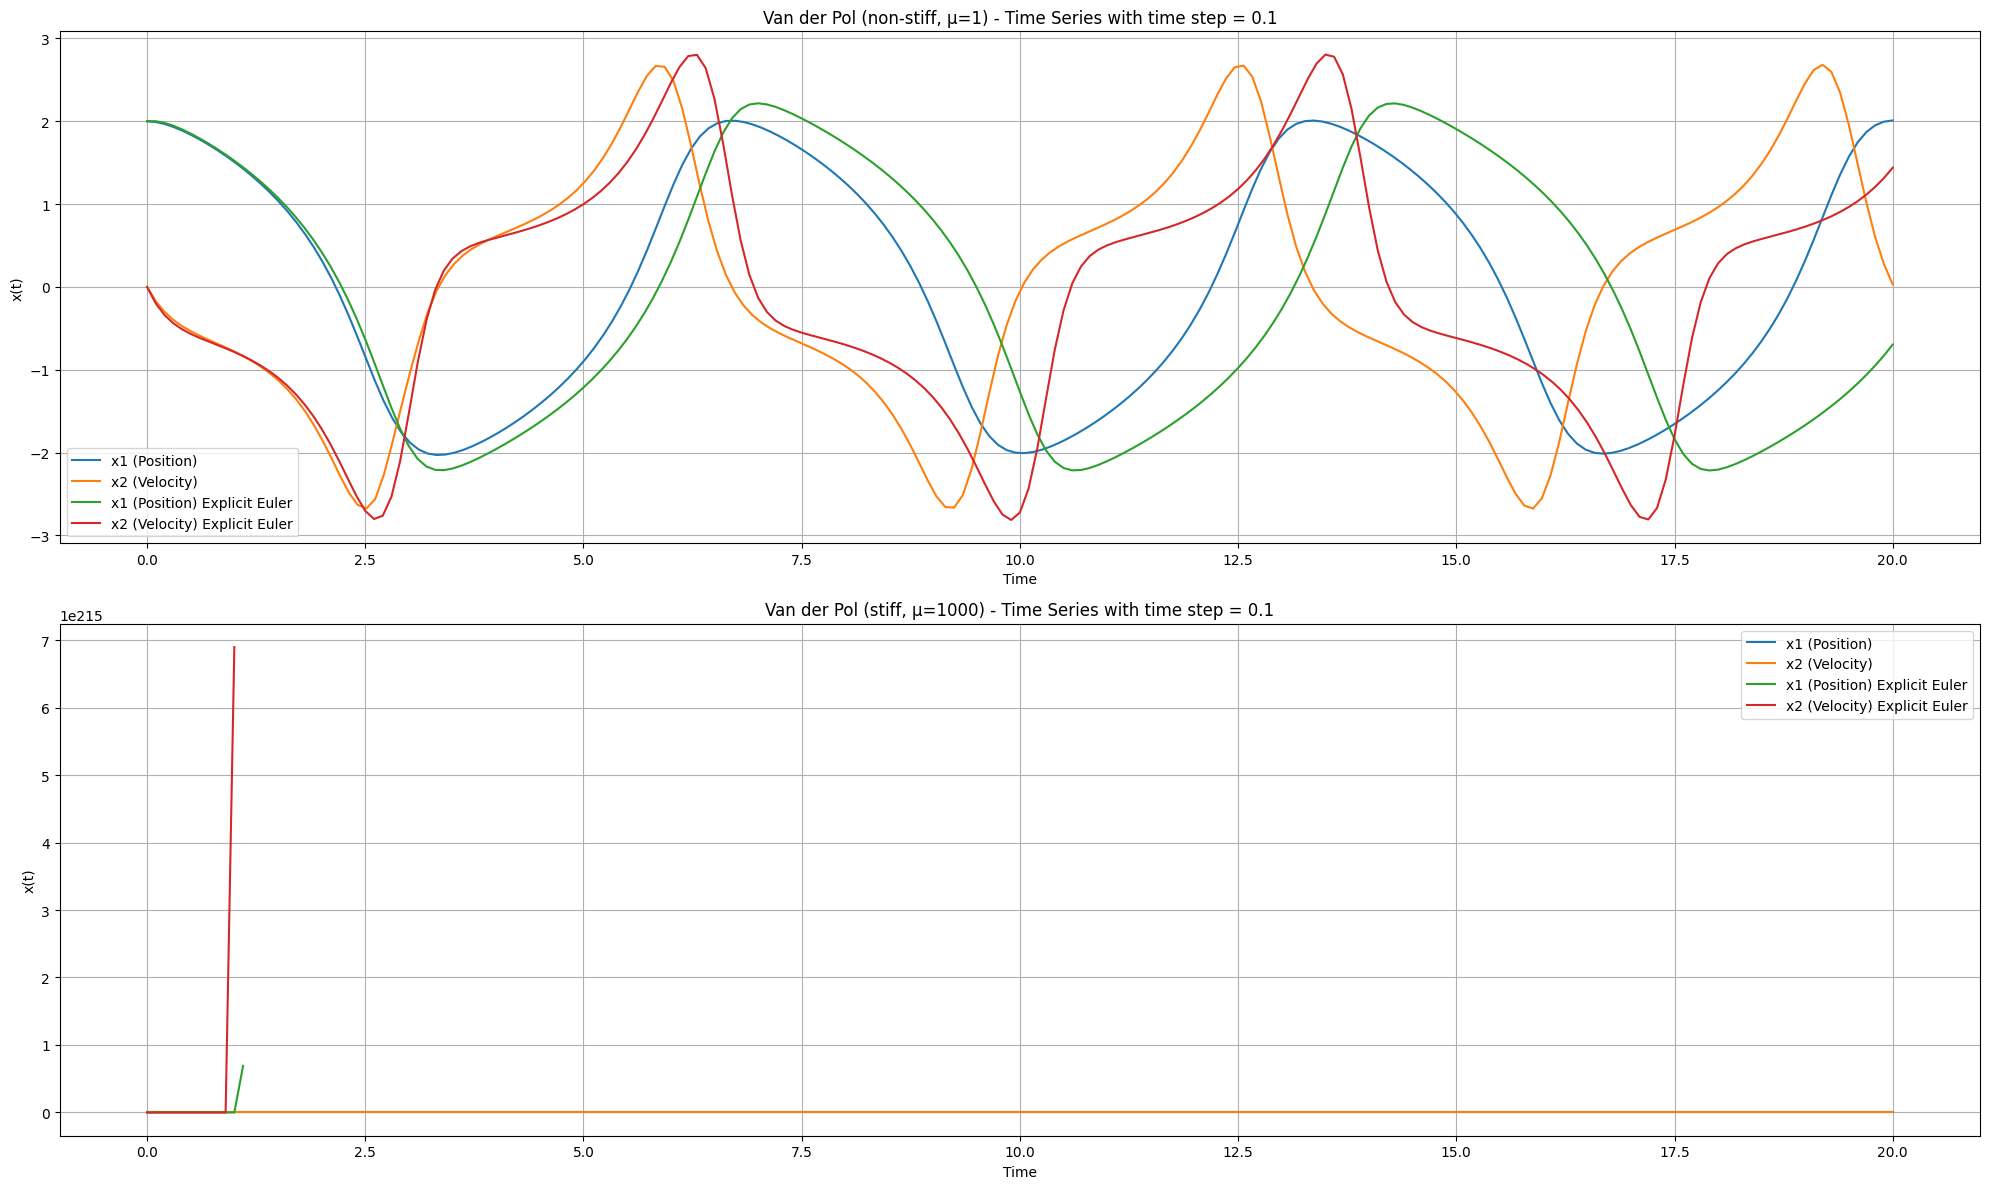

In [57]:
# Define time span and initial conditions
mu_nonstiff = 1  # Non-stiff
mu_stiff = 100  # Stiff
t_span = (0, 20)
x0 = np.array([2, 0])  # Initial condition

f_stiff, _ = van_der_pol_model(mu_stiff)
f_nonstiff, _ = van_der_pol_model(mu_nonstiff)


#Solver parameters
N = 200


# Solve using ode45 (method='RK45')
sol_nonstiff = solve_ivp(f_nonstiff, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], N))
solution_fixed_nonstiff_t, solution_fixed_nonstiff_x = ExplicitEulerFixedSteps(f_nonstiff, t_span[0], t_span[1], N, x0)


sol_stiff = solve_ivp(f_stiff, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], N))
solution_fixed_stiff_t, solution_fixed_stiff_x = ExplicitEulerFixedSteps(f_stiff, t_span[0], t_span[1], N, x0)


#Plot two plots one for the non-stiff solutions and one for the stiff-solutions
plt.figure(figsize=(20,12))

# Plot time series for non-stiff
plt.subplot(2, 1, 1)
plt.plot(sol_nonstiff.t, sol_nonstiff.y[0], label='x1 (Position)')
plt.plot(sol_nonstiff.t, sol_nonstiff.y[1], label='x2 (Velocity)')
plt.plot(solution_fixed_nonstiff_t, solution_fixed_nonstiff_x[0], label = 'x1 (Position) Explicit Euler')
plt.plot(solution_fixed_nonstiff_t, solution_fixed_nonstiff_x[1], label = 'x2 (Velocity) Explicit Euler')
plt.legend()
plt.title('Van der Pol (non-stiff, μ=1) - Time Series with time step = 0.1')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.grid()
plt.tight_layout()

# Plot time series for stiff
plt.subplot(2, 1, 2)
plt.plot(sol_stiff.t, sol_stiff.y[0], label = 'x1 (Position)')
plt.plot(sol_stiff.t, sol_stiff.y[1], label = 'x2 (Velocity)')
plt.plot(solution_fixed_stiff_t, solution_fixed_stiff_x[0], label = 'x1 (Position) Explicit Euler')
plt.plot(solution_fixed_stiff_t, solution_fixed_stiff_x[1], label = 'x2 (Velocity) Explicit Euler')
plt.legend()
plt.title('Van der Pol (stiff, μ=1000) - Time Series with time step = 0.1')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.grid()
plt.tight_layout()

#### Explicit Euler with fixed step size = 0.01

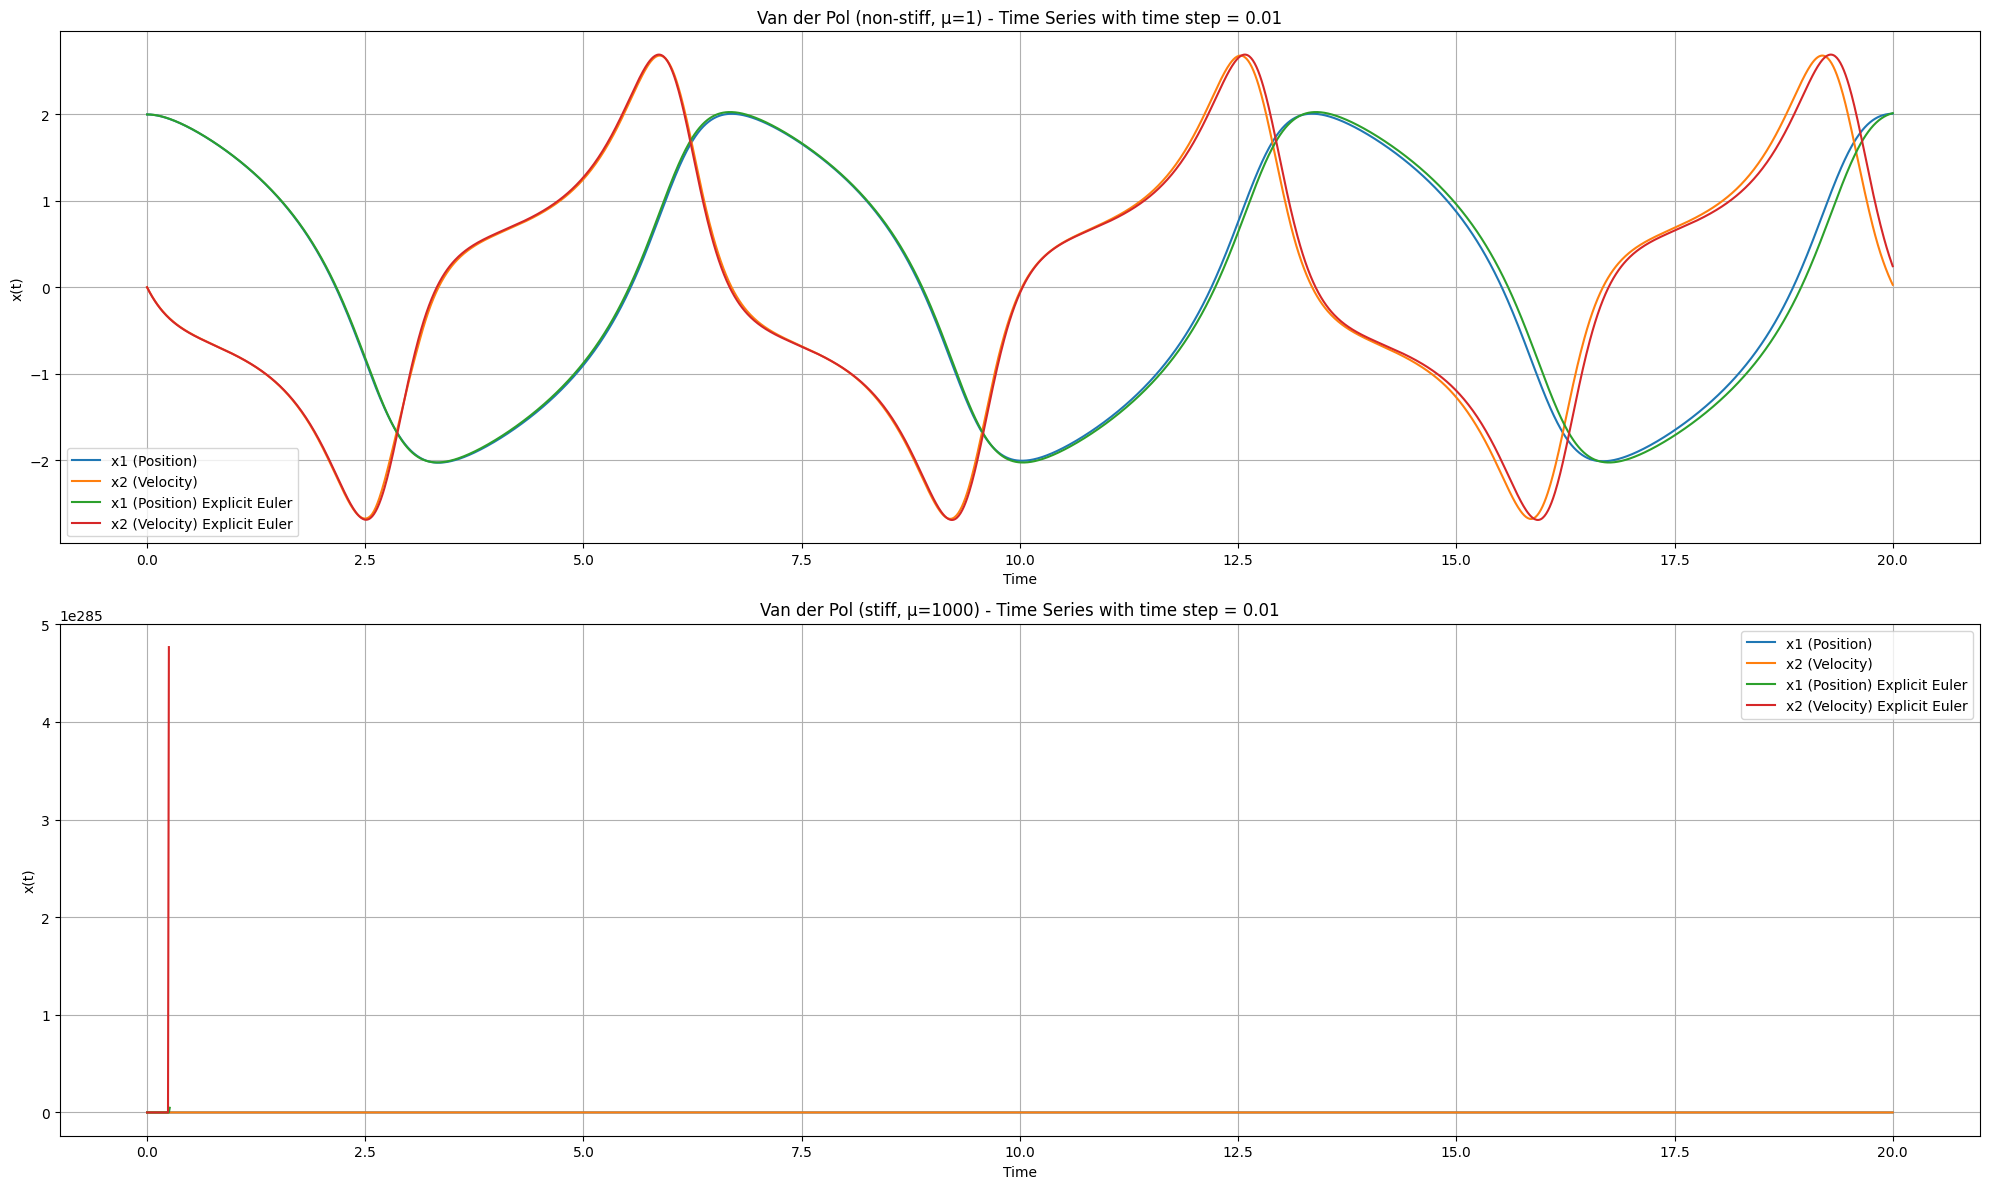

In [58]:
# Define time span and initial conditions
mu_nonstiff = 1  # Non-stiff
mu_stiff = 100  # Stiff
t_span = (0, 20)
x0 = np.array([2, 0])  # Initial condition

f_stiff, _ = van_der_pol_model(mu_stiff)
f_nonstiff, _ = van_der_pol_model(mu_nonstiff)


#Solver parameters
N = 2000


# Solve using ode45 (method='RK45')
sol_nonstiff = solve_ivp(f_nonstiff, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], N))
solution_fixed_nonstiff_t, solution_fixed_nonstiff_x = ExplicitEulerFixedSteps(f_nonstiff, t_span[0], t_span[1], N, x0)


sol_stiff = solve_ivp(f_stiff, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], N))
solution_fixed_stiff_t, solution_fixed_stiff_x = ExplicitEulerFixedSteps(f_stiff, t_span[0], t_span[1], N, x0)


#Plot two plots one for the non-stiff solutions and one for the stiff-solutions
plt.figure(figsize=(20,12))

# Plot time series for non-stiff
plt.subplot(2, 1, 1)
plt.plot(sol_nonstiff.t, sol_nonstiff.y[0], label='x1 (Position)')
plt.plot(sol_nonstiff.t, sol_nonstiff.y[1], label='x2 (Velocity)')
plt.plot(solution_fixed_nonstiff_t, solution_fixed_nonstiff_x[0], label = 'x1 (Position) Explicit Euler')
plt.plot(solution_fixed_nonstiff_t, solution_fixed_nonstiff_x[1], label = 'x2 (Velocity) Explicit Euler')
plt.legend()
plt.title('Van der Pol (non-stiff, μ=1) - Time Series with time step = 0.01')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.grid()
plt.tight_layout()

# Plot time series for stiff
plt.subplot(2, 1, 2)
plt.plot(sol_stiff.t, sol_stiff.y[0], label = 'x1 (Position)')
plt.plot(sol_stiff.t, sol_stiff.y[1], label = 'x2 (Velocity)')
plt.plot(solution_fixed_stiff_t, solution_fixed_stiff_x[0], label = 'x1 (Position) Explicit Euler')
plt.plot(solution_fixed_stiff_t, solution_fixed_stiff_x[1], label = 'x2 (Velocity) Explicit Euler')
plt.legend()
plt.title('Van der Pol (stiff, μ=1000) - Time Series with time step = 0.01')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.grid()
plt.tight_layout()

#### Explicit Euler with adaptive time step and tolerance 10^-6

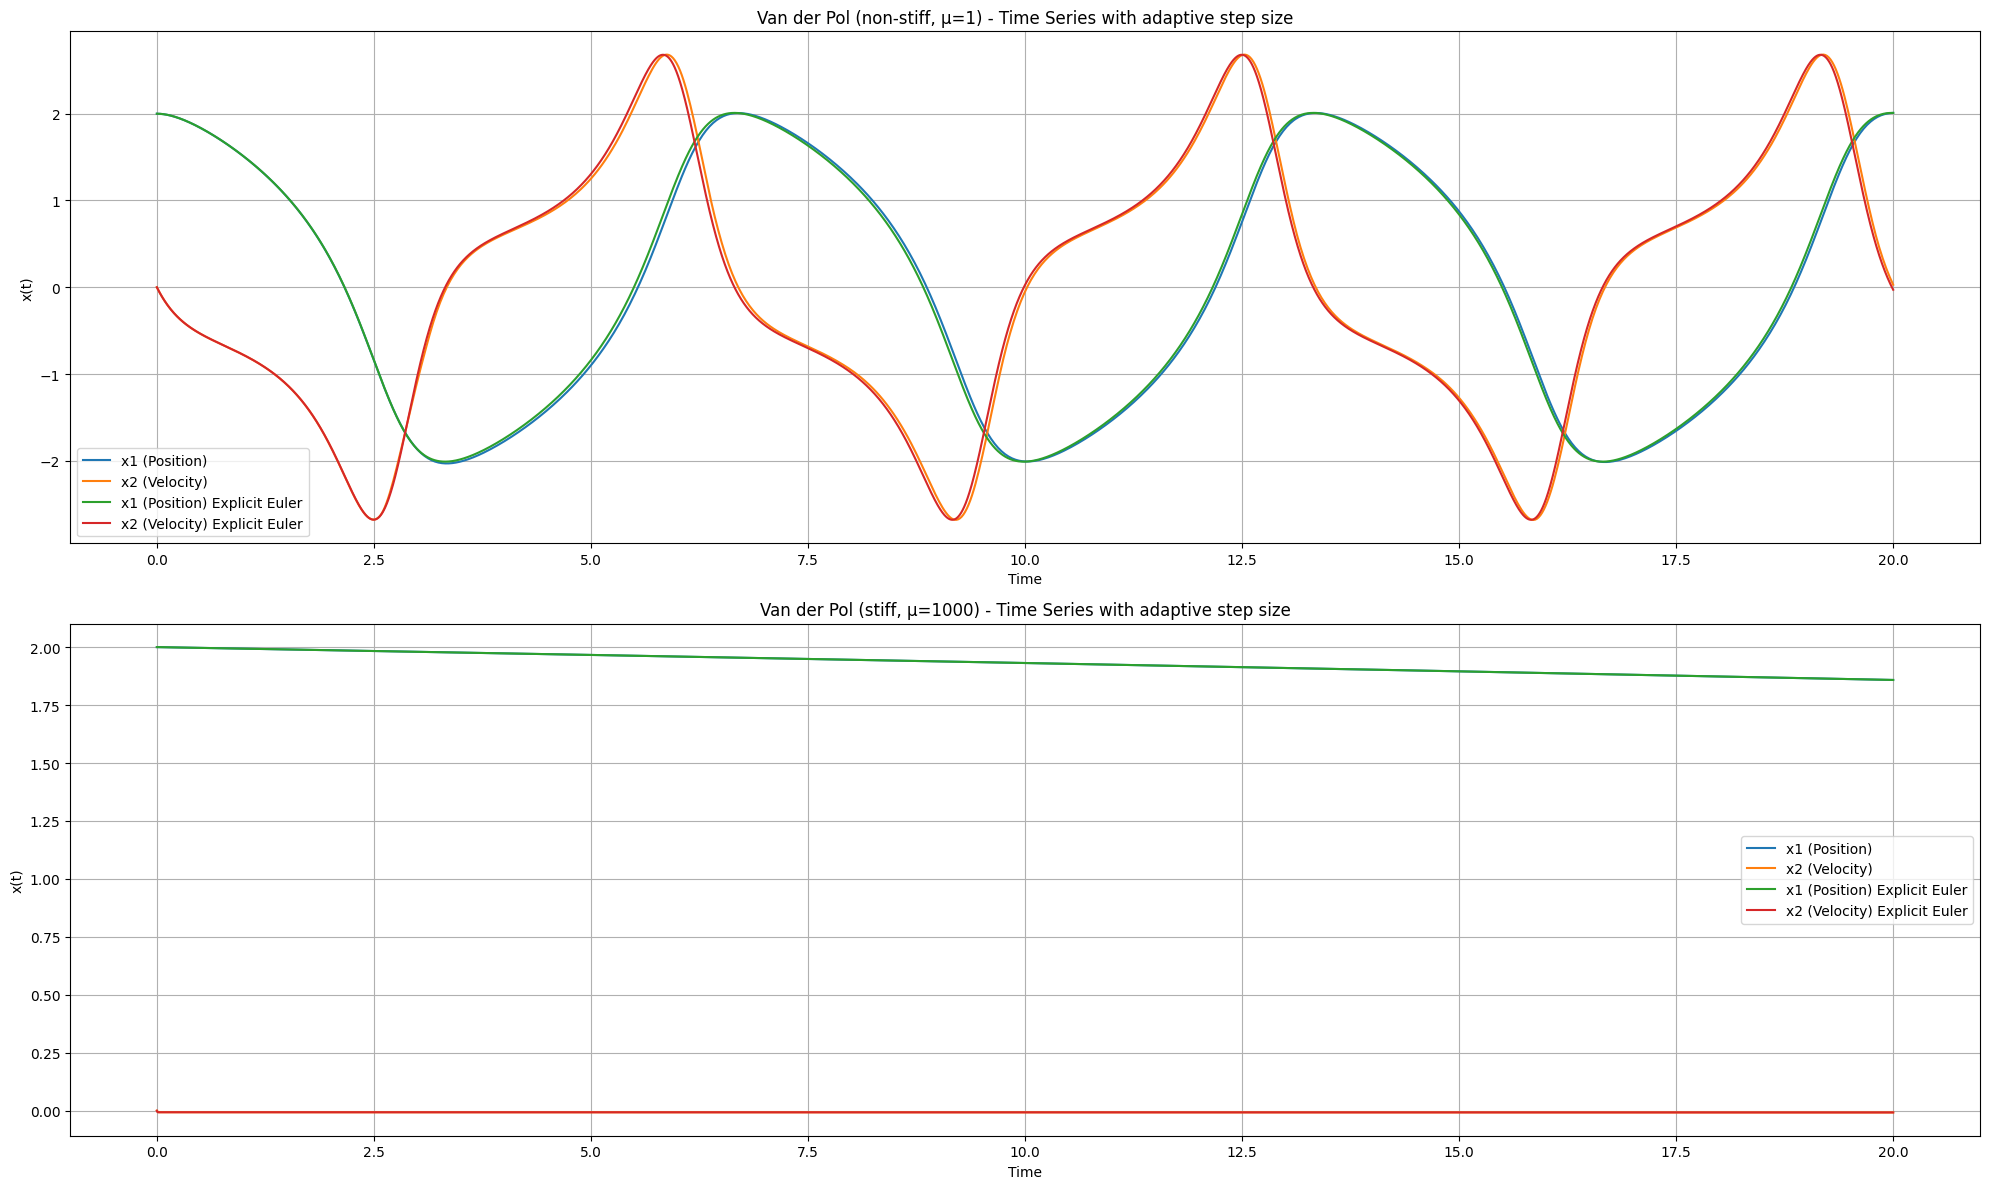

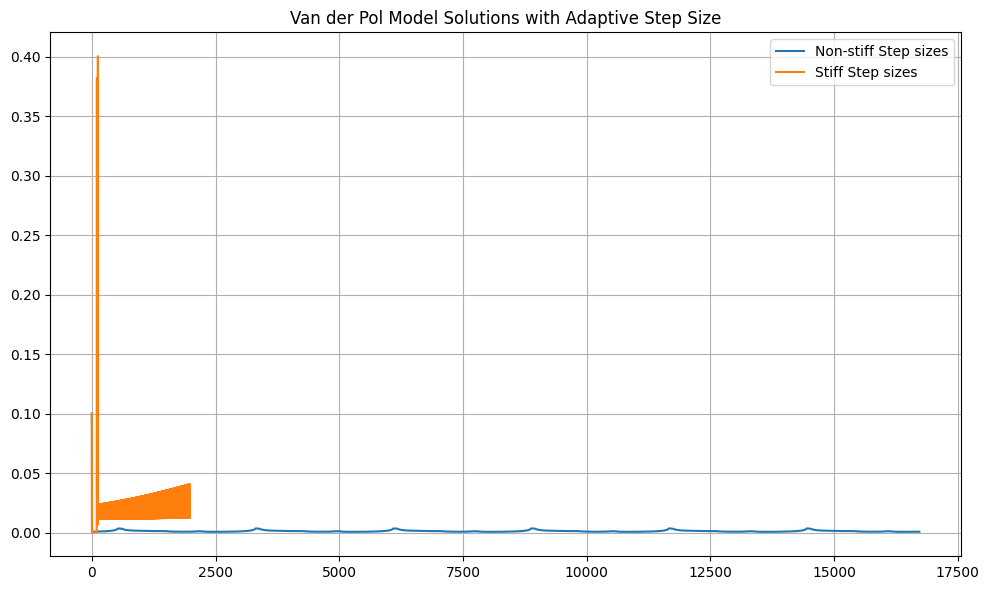

In [52]:
# Define time span and initial conditions
mu_nonstiff = 1  # Non-stiff
mu_stiff = 100  # Stiff
t_span = (0, 20)
x0 = np.array([2, 0])  # Initial condition

f_stiff, _ = van_der_pol_model(mu_stiff)
f_nonstiff, _ = van_der_pol_model(mu_nonstiff)


#Solver parameters
h0 = 0.1

abs_tol = 1e-6
rel_tol = 1e-6


# Solve using ode45 (method='RK45')
sol_nonstiff = solve_ivp(f_nonstiff, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], N))
solution_adaptive_nonstiff_t, solution_adaptive_nonstiff_x, solution_adaptive_nonstiff_h = ExplicitEulerAdaptiveStep(f_nonstiff, t_span, x0, h0, abs_tol, rel_tol)


sol_stiff = solve_ivp(f_stiff, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], N))
solution_adaptive_stiff_t, solution_adaptive_stiff_x, solution_adaptive_stiff_h = ExplicitEulerAdaptiveStep(f_stiff, t_span, x0, h0, abs_tol, rel_tol)


#Plot two plots one for the non-stiff solutions and one for the stiff-solutions
plt.figure(figsize=(20,12))

# Plot time series for non-stiff
plt.subplot(2, 1, 1)
plt.plot(sol_nonstiff.t, sol_nonstiff.y[0], label='x1 (Position)')
plt.plot(sol_nonstiff.t, sol_nonstiff.y[1], label='x2 (Velocity)')
plt.plot(solution_adaptive_nonstiff_t, solution_adaptive_nonstiff_x[:,0], label = 'x1 (Position) Explicit Euler')
plt.plot(solution_adaptive_nonstiff_t, solution_adaptive_nonstiff_x[:,1], label = 'x2 (Velocity) Explicit Euler')
plt.legend()
plt.title('Van der Pol (non-stiff, μ=1) - Time Series with adaptive step size')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.grid()
plt.tight_layout()

# Plot time series for stiff
plt.subplot(2, 1, 2)
plt.plot(sol_stiff.t, sol_stiff.y[0], label = 'x1 (Position)')
plt.plot(sol_stiff.t, sol_stiff.y[1], label = 'x2 (Velocity)')
plt.plot(solution_adaptive_stiff_t, solution_adaptive_stiff_x[:,0], label = 'x1 (Position) Explicit Euler')
plt.plot(solution_adaptive_stiff_t, solution_adaptive_stiff_x[:,1], label = 'x2 (Velocity) Explicit Euler')
plt.legend()
plt.title('Van der Pol (stiff, μ=1000) - Time Series with adaptive step size')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.grid()
plt.tight_layout()


#Plot the stepsizes in solution_adaptive_h
plt.figure(figsize=(10, 6))
plt.plot(solution_adaptive_nonstiff_h, label = 'Non-stiff Step sizes')
plt.plot(solution_adaptive_stiff_h, label = 'Stiff Step sizes')
plt.title('Van der Pol Model Solutions with Adaptive Step Size')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Explicit Euler with adaptive time step and tolerance 10^-3

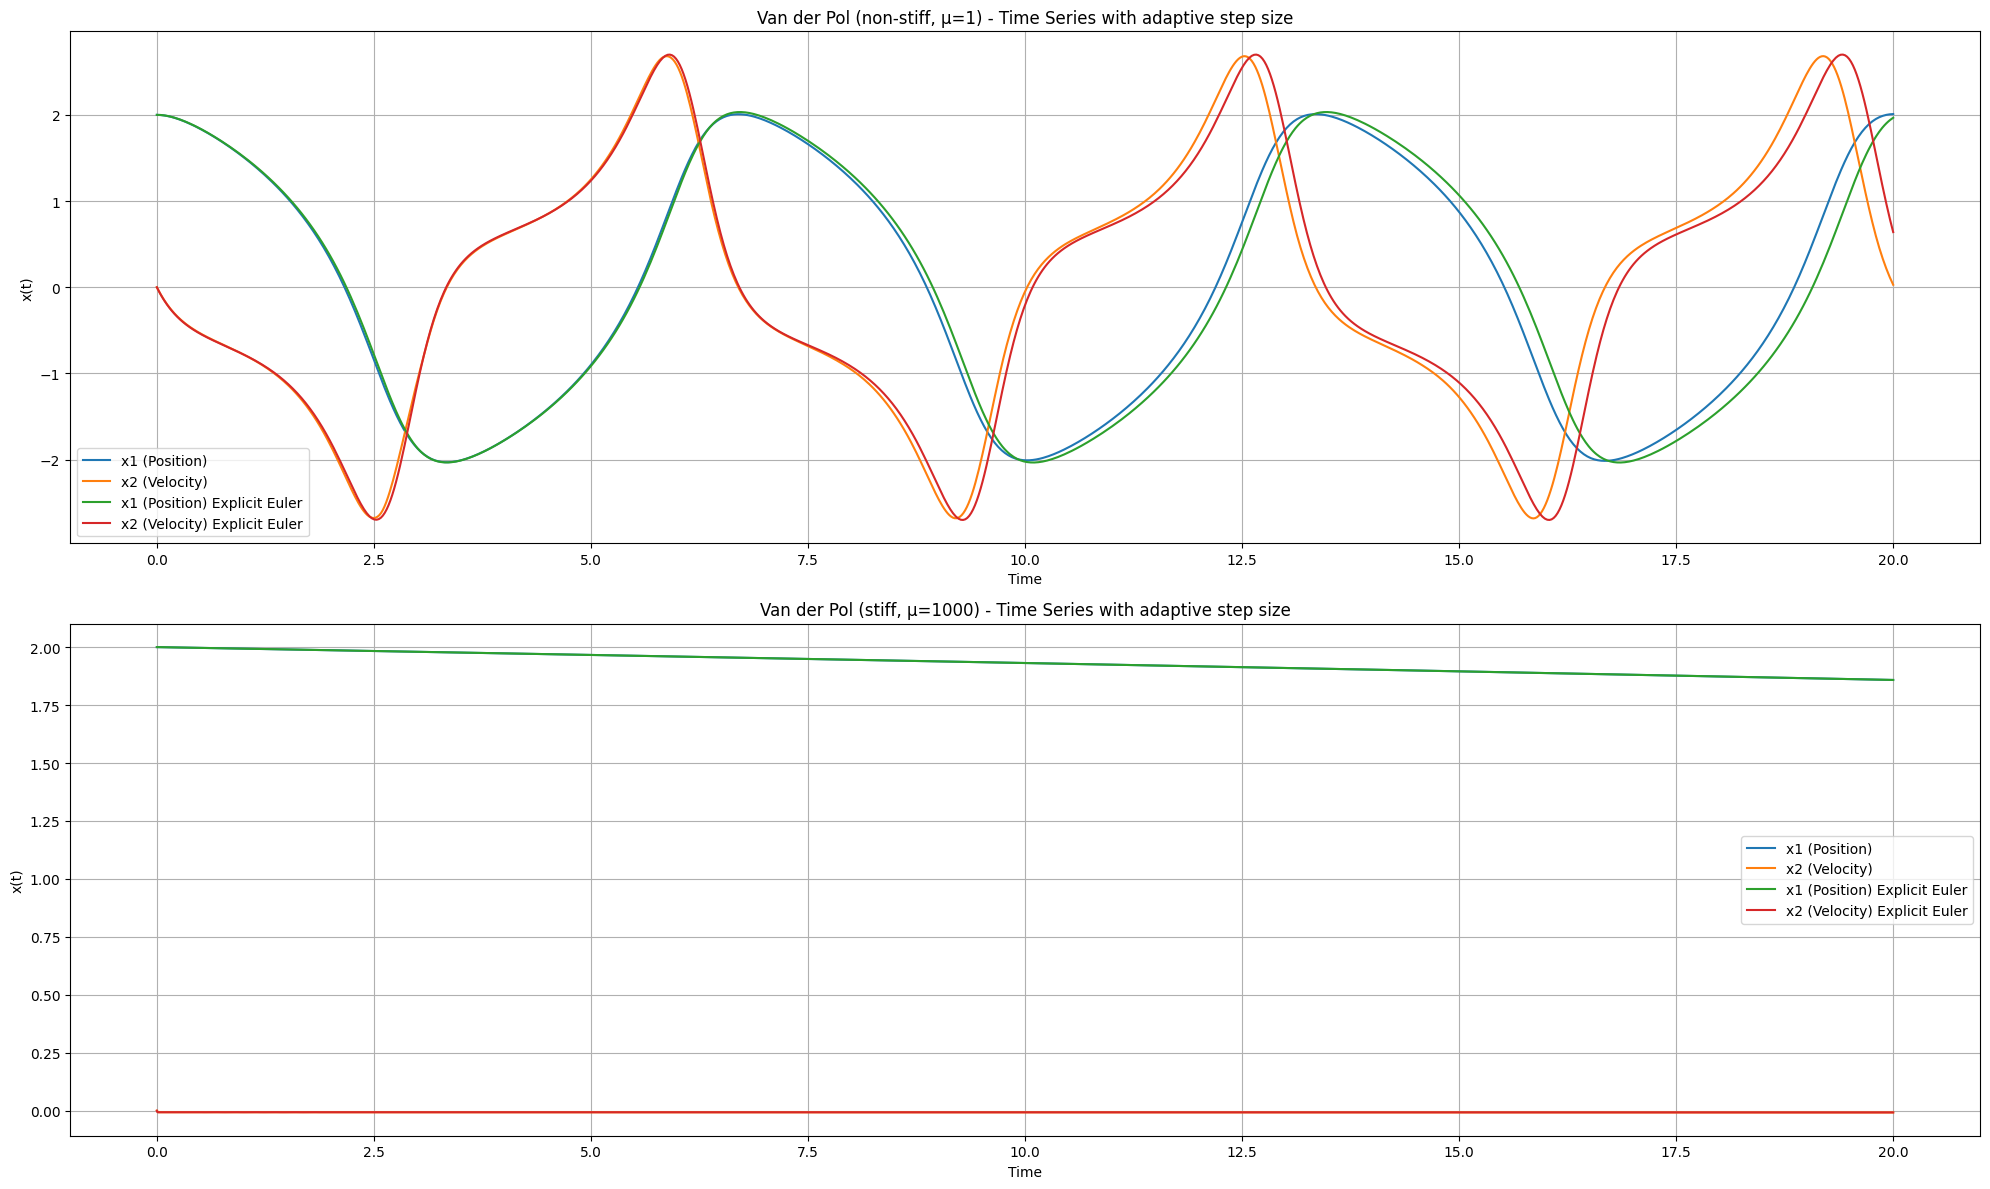

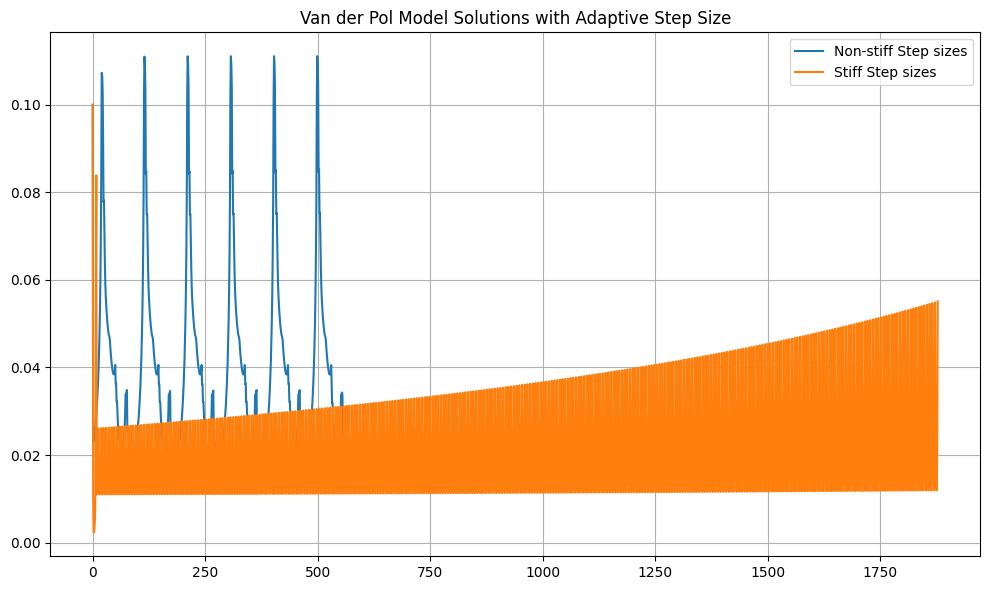

In [53]:
# Define time span and initial conditions
mu_nonstiff = 1  # Non-stiff
mu_stiff = 100  # Stiff
t_span = (0, 20)
x0 = np.array([2, 0])  # Initial condition

f_stiff, _ = van_der_pol_model(mu_stiff)
f_nonstiff, _ = van_der_pol_model(mu_nonstiff)


#Solver parameters
h0 = 0.1

abs_tol = 1e-3
rel_tol = 1e-3


# Solve using ode45 (method='RK45')
sol_nonstiff = solve_ivp(f_nonstiff, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], N))
solution_adaptive_nonstiff_t, solution_adaptive_nonstiff_x, solution_adaptive_nonstiff_h = ExplicitEulerAdaptiveStep(f_nonstiff, t_span, x0, h0, abs_tol, rel_tol)


sol_stiff = solve_ivp(f_stiff, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], N))
solution_adaptive_stiff_t, solution_adaptive_stiff_x, solution_adaptive_stiff_h = ExplicitEulerAdaptiveStep(f_stiff, t_span, x0, h0, abs_tol, rel_tol)


#Plot two plots one for the non-stiff solutions and one for the stiff-solutions
plt.figure(figsize=(20,12))

# Plot time series for non-stiff
plt.subplot(2, 1, 1)
plt.plot(sol_nonstiff.t, sol_nonstiff.y[0], label='x1 (Position)')
plt.plot(sol_nonstiff.t, sol_nonstiff.y[1], label='x2 (Velocity)')
plt.plot(solution_adaptive_nonstiff_t, solution_adaptive_nonstiff_x[:,0], label = 'x1 (Position) Explicit Euler')
plt.plot(solution_adaptive_nonstiff_t, solution_adaptive_nonstiff_x[:,1], label = 'x2 (Velocity) Explicit Euler')
plt.legend()
plt.title('Van der Pol (non-stiff, μ=1) - Time Series with adaptive step size')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.grid()
plt.tight_layout()

# Plot time series for stiff
plt.subplot(2, 1, 2)
plt.plot(sol_stiff.t, sol_stiff.y[0], label = 'x1 (Position)')
plt.plot(sol_stiff.t, sol_stiff.y[1], label = 'x2 (Velocity)')
plt.plot(solution_adaptive_stiff_t, solution_adaptive_stiff_x[:,0], label = 'x1 (Position) Explicit Euler')
plt.plot(solution_adaptive_stiff_t, solution_adaptive_stiff_x[:,1], label = 'x2 (Velocity) Explicit Euler')
plt.legend()
plt.title('Van der Pol (stiff, μ=1000) - Time Series with adaptive step size')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.grid()
plt.tight_layout()

#Plot the stepsizes in solution_adaptive_h
plt.figure(figsize=(10, 6))
plt.plot(solution_adaptive_nonstiff_h, label = 'Non-stiff Step sizes')
plt.plot(solution_adaptive_stiff_h, label = 'Stiff Step sizes')
plt.title('Van der Pol Model Solutions with Adaptive Step Size')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### CSTR (3 state model)

#### Explicit Euler with fixed step size = 0.1

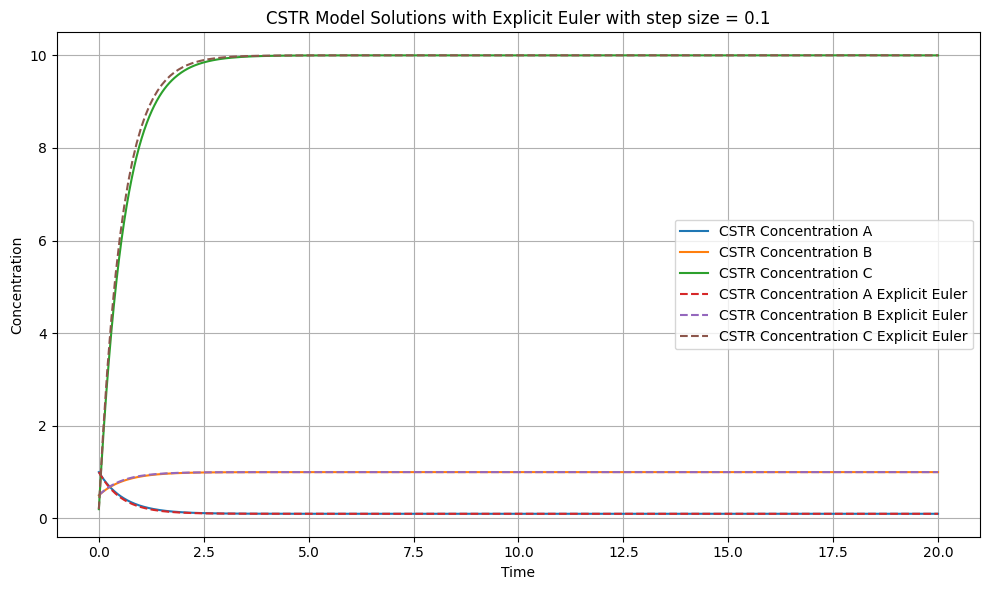

In [62]:
#Parameters
params = [0.5,0.3,0.1,1.0,10.0]
t_span = (0, 20)
x0 = np.array([1.0, 0.5, 0.2])  # Initial conditions for CSTR model

#Solver parameters
N = 200

f, _ = CSTR_3state_model(params)

# Solve using odeint
sol = solve_ivp(f, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], 1000))
solution_fixed_t, solution_fixed_x = ExplicitEulerFixedSteps(f, t_span[0], t_span[1], N, x0)

#Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='CSTR Concentration A')
plt.plot(sol.t, sol.y[1], label='CSTR Concentration B') 
plt.plot(sol.t, sol.y[2], label='CSTR Concentration C')
plt.plot(solution_fixed_t, solution_fixed_x[0], label='CSTR Concentration A Explicit Euler', linestyle='--')
plt.plot(solution_fixed_t, solution_fixed_x[1], label='CSTR Concentration B Explicit Euler', linestyle='--')
plt.plot(solution_fixed_t, solution_fixed_x[2], label='CSTR Concentration C Explicit Euler', linestyle='--')
plt.title('CSTR Model Solutions with Explicit Euler with step size = 0.1')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Explicit Euler with fixed step size = 0.01

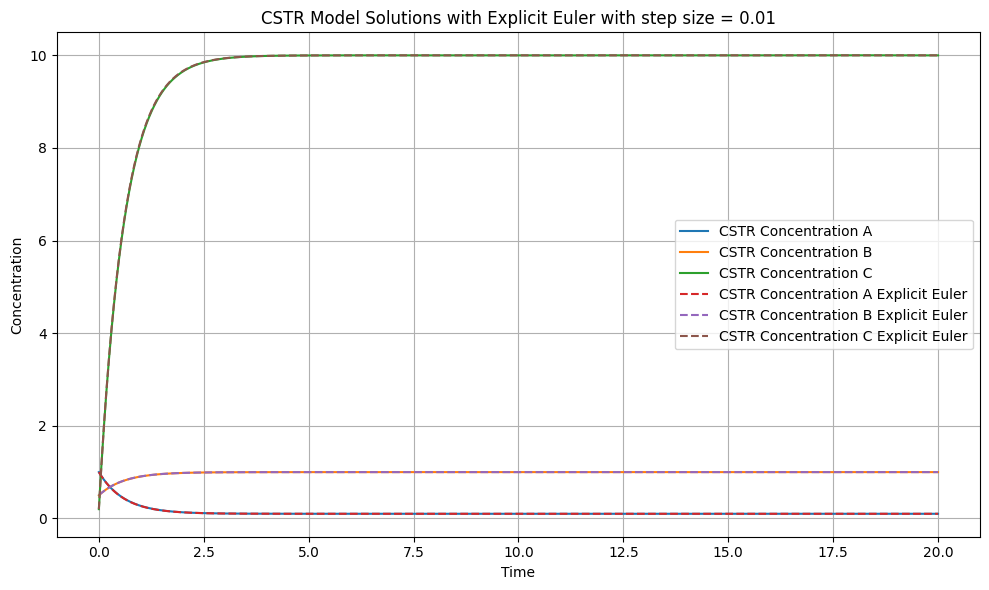

In [63]:
#Parameters
params = [0.5,0.3,0.1,1.0,10.0]
t_span = (0, 20)
x0 = np.array([1.0, 0.5, 0.2])  # Initial conditions for CSTR model

#Solver parameters
N = 2000

f, _ = CSTR_3state_model(params)

# Solve using odeint
sol = solve_ivp(f, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], 1000))
solution_fixed_t, solution_fixed_x = ExplicitEulerFixedSteps(f, t_span[0], t_span[1], N, x0)

#Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='CSTR Concentration A')
plt.plot(sol.t, sol.y[1], label='CSTR Concentration B') 
plt.plot(sol.t, sol.y[2], label='CSTR Concentration C')
plt.plot(solution_fixed_t, solution_fixed_x[0], label='CSTR Concentration A Explicit Euler', linestyle='--')
plt.plot(solution_fixed_t, solution_fixed_x[1], label='CSTR Concentration B Explicit Euler', linestyle='--')
plt.plot(solution_fixed_t, solution_fixed_x[2], label='CSTR Concentration C Explicit Euler', linestyle='--')
plt.title('CSTR Model Solutions with Explicit Euler with step size = 0.01')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Explicit Euler with adaptive time step with tolerance 10^-6

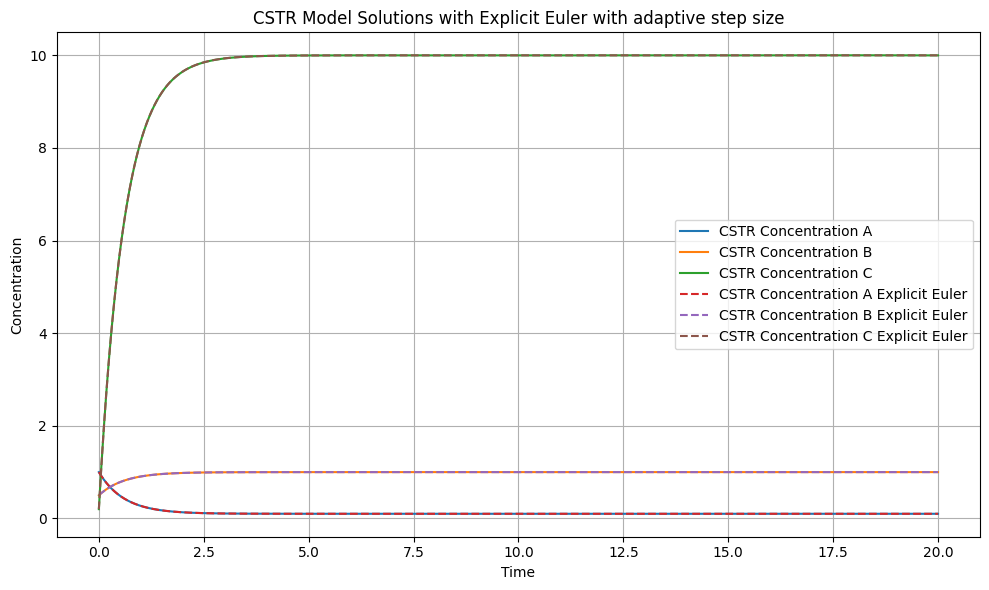

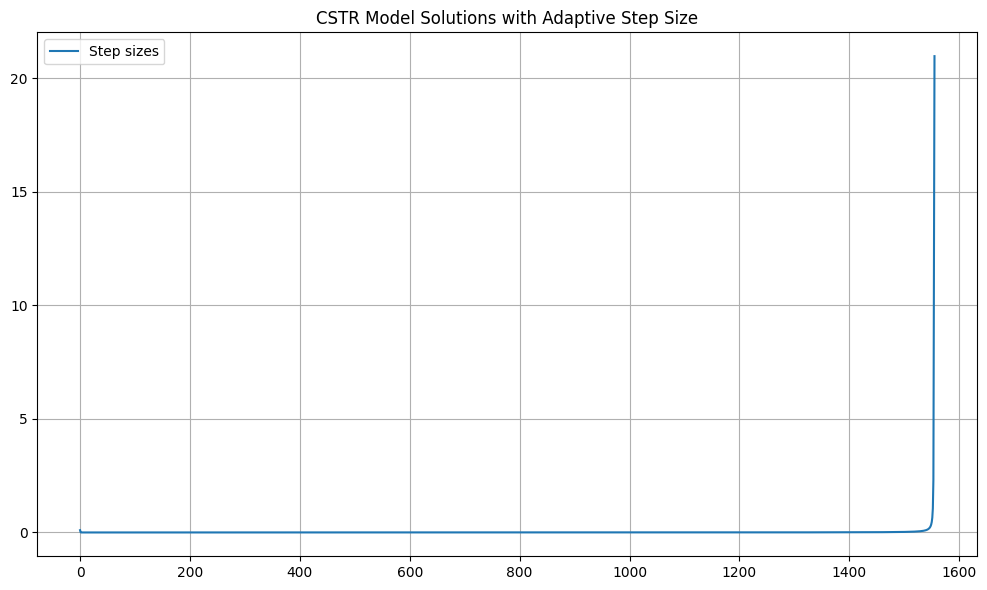

In [66]:
#Solver parameters
h0 = 0.1

abs_tol = 1e-6
rel_tol = 1e-6

solution_adaptive_t, solution_adaptive_x, solution_adaptive_h = ExplicitEulerAdaptiveStep(f, t_span, x0, h0, abs_tol, rel_tol)

#Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='CSTR Concentration A')
plt.plot(sol.t, sol.y[1], label='CSTR Concentration B')
plt.plot(sol.t, sol.y[2], label='CSTR Concentration C')
plt.plot(solution_adaptive_t, solution_adaptive_x[:,0], label='CSTR Concentration A Explicit Euler', linestyle='--')
plt.plot(solution_adaptive_t, solution_adaptive_x[:,1], label='CSTR Concentration B Explicit Euler', linestyle='--')
plt.plot(solution_adaptive_t, solution_adaptive_x[:,2], label='CSTR Concentration C Explicit Euler', linestyle='--')
plt.title('CSTR Model Solutions with Explicit Euler with adaptive step size')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
#Plot the stepsizes in solution_adaptive_h
plt.figure(figsize=(10, 6))
plt.plot(solution_adaptive_h, label = 'Step sizes')
plt.title('CSTR Model Solutions with Adaptive Step Size')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Explicit Euler with adaptive time step with tolerance 10^-3

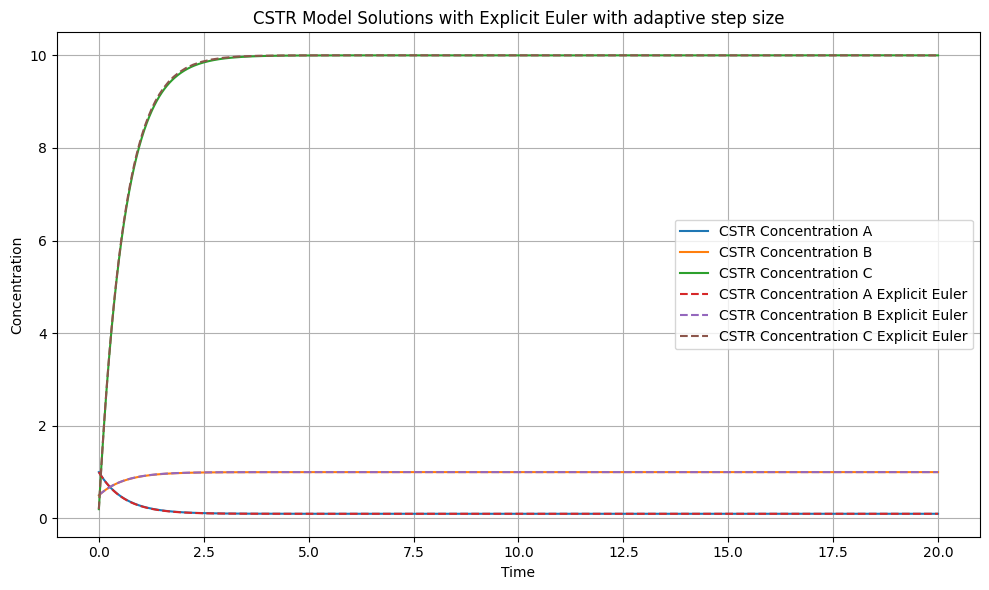

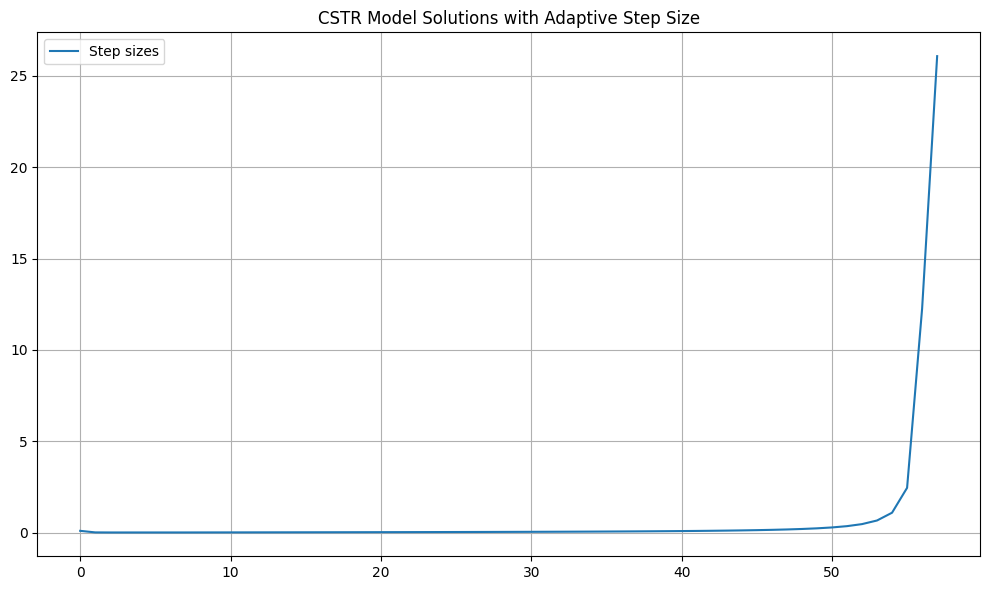

In [67]:
#Solver parameters
h0 = 0.1

abs_tol = 1e-3
rel_tol = 1e-3

solution_adaptive_t, solution_adaptive_x, solution_adaptive_h = ExplicitEulerAdaptiveStep(f, t_span, x0, h0, abs_tol, rel_tol)

#Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='CSTR Concentration A')
plt.plot(sol.t, sol.y[1], label='CSTR Concentration B')
plt.plot(sol.t, sol.y[2], label='CSTR Concentration C')
plt.plot(solution_adaptive_t, solution_adaptive_x[:,0], label='CSTR Concentration A Explicit Euler', linestyle='--')
plt.plot(solution_adaptive_t, solution_adaptive_x[:,1], label='CSTR Concentration B Explicit Euler', linestyle='--')
plt.plot(solution_adaptive_t, solution_adaptive_x[:,2], label='CSTR Concentration C Explicit Euler', linestyle='--')
plt.title('CSTR Model Solutions with Explicit Euler with adaptive step size')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
#Plot the stepsizes in solution_adaptive_h
plt.figure(figsize=(10, 6))
plt.plot(solution_adaptive_h, label = 'Step sizes')
plt.title('CSTR Model Solutions with Adaptive Step Size')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### CSTR (1 state model)

#### Explicit Euler with fixed step size = 0.1

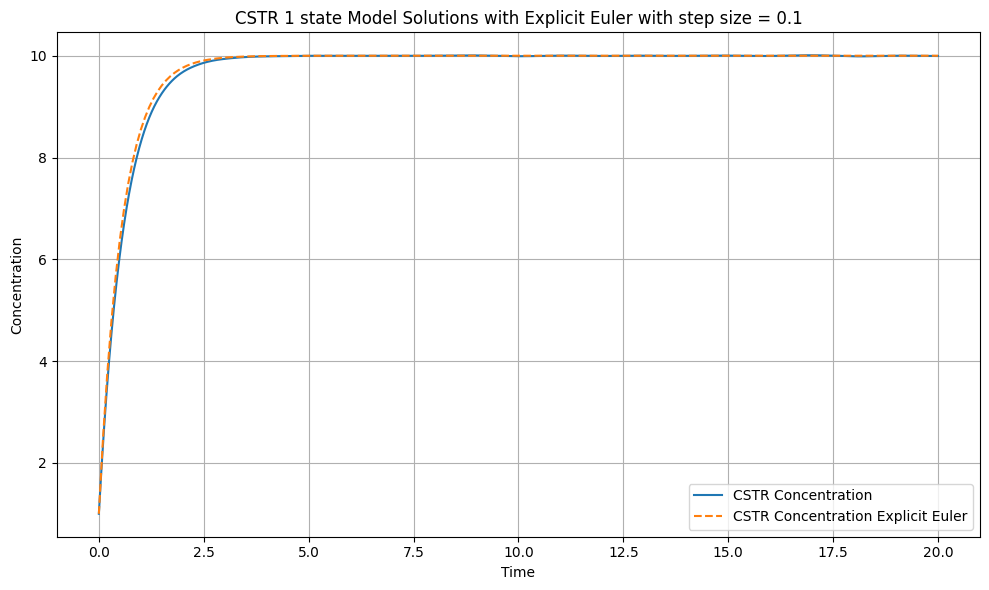

In [71]:
#Parameters
params = [0.5,0.3,0.1,1.0,10.0]
t_span = (0, 20)
x0 = np.array([1.0])  # Initial conditions for CSTR model

#Solver parameters
N = 200

f, _ = CSTR_1state_model(params)

# Solve using odeint
sol = solve_ivp(f, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], 1000))
solution_fixed_t, solution_fixed_x = ExplicitEulerFixedSteps(f, t_span[0], t_span[1], N, x0)

#Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='CSTR Concentration')
plt.plot(solution_fixed_t, solution_fixed_x[0], label='CSTR Concentration Explicit Euler', linestyle='--')
plt.title('CSTR 1 state Model Solutions with Explicit Euler with step size = 0.1')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Explicit Euler with fixed step size = 0.01

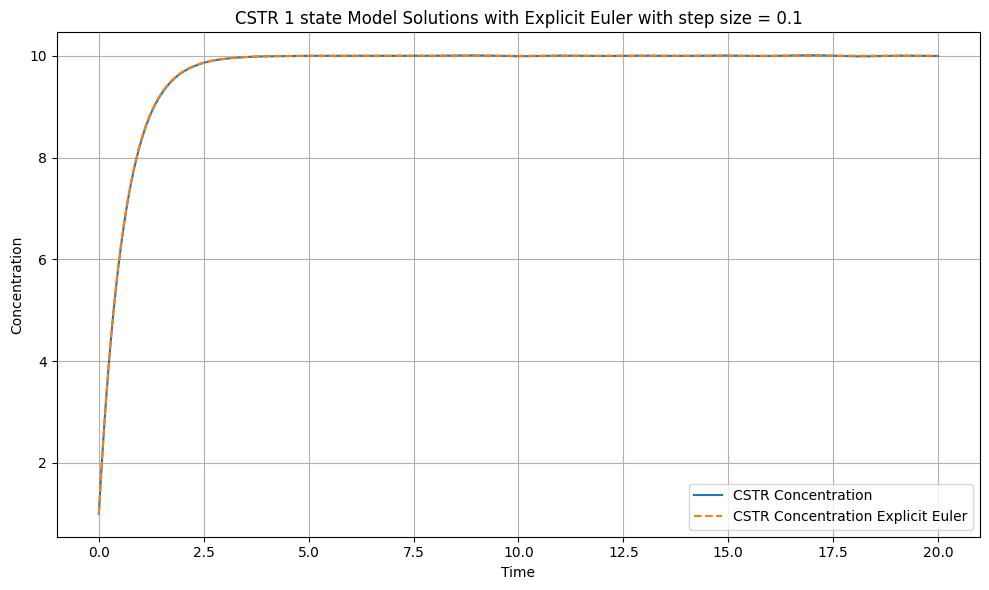

In [72]:
#Parameters
params = [0.5,0.3,0.1,1.0,10.0]
t_span = (0, 20)
x0 = np.array([1.0])  # Initial conditions for CSTR model

#Solver parameters
N = 2000

f, _ = CSTR_1state_model(params)

# Solve using odeint
sol = solve_ivp(f, t_span, x0, method='RK45', t_eval=np.linspace(t_span[0], t_span[1], 1000))
solution_fixed_t, solution_fixed_x = ExplicitEulerFixedSteps(f, t_span[0], t_span[1], N, x0)

#Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='CSTR Concentration')
plt.plot(solution_fixed_t, solution_fixed_x[0], label='CSTR Concentration Explicit Euler', linestyle='--')
plt.title('CSTR 1 state Model Solutions with Explicit Euler with step size = 0.1')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Explicit Euler with adaptive time step and tolerance 10^-6

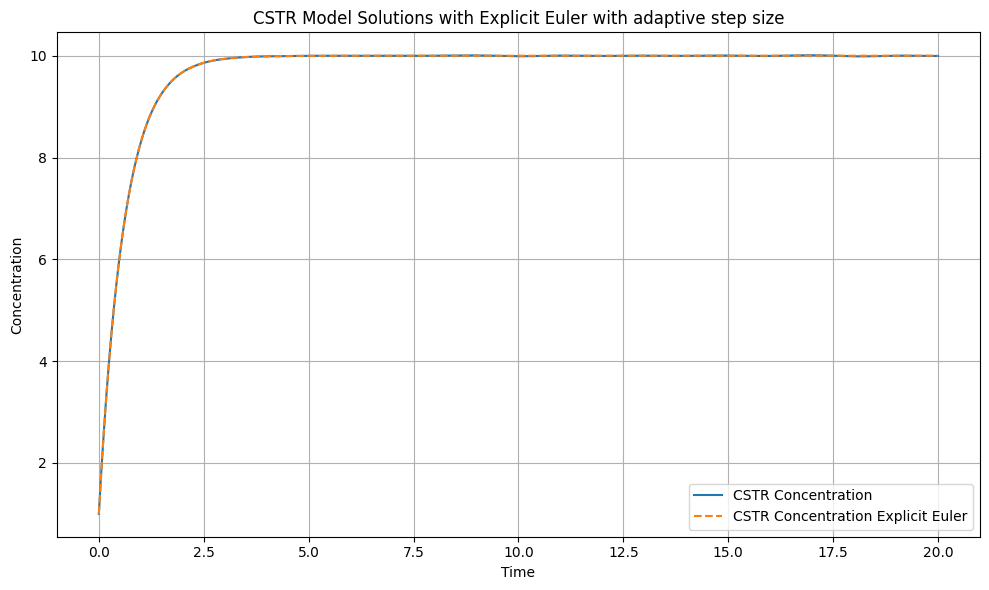

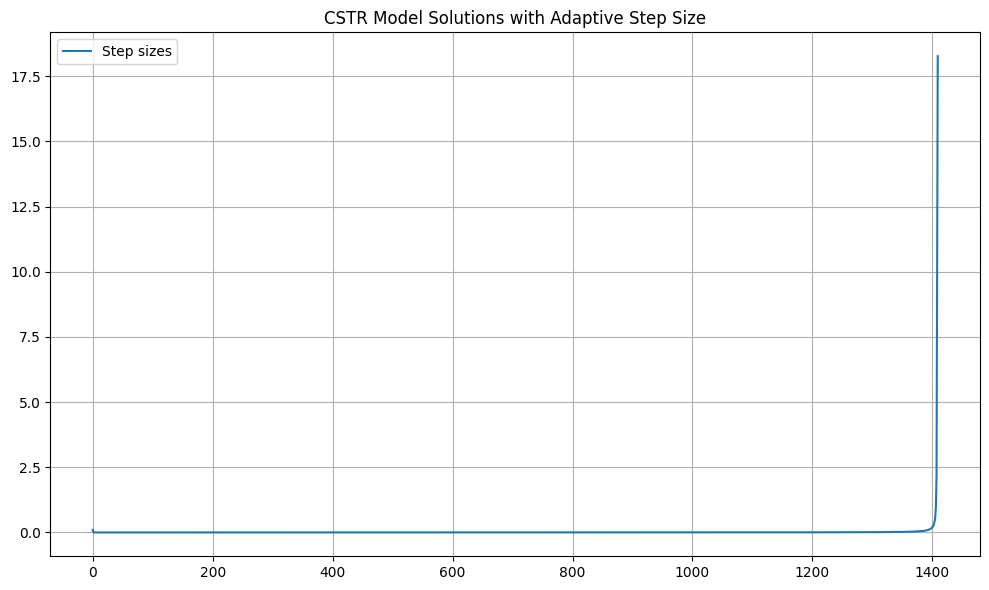

In [73]:
#Solver parameters
h0 = 0.1

abs_tol = 1e-6
rel_tol = 1e-6

solution_adaptive_t, solution_adaptive_x, solution_adaptive_h = ExplicitEulerAdaptiveStep(f, t_span, x0, h0, abs_tol, rel_tol)

#Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='CSTR Concentration')
plt.plot(solution_adaptive_t, solution_adaptive_x[:,0], label='CSTR Concentration Explicit Euler', linestyle='--')
plt.title('CSTR Model Solutions with Explicit Euler with adaptive step size')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
#Plot the stepsizes in solution_adaptive_h
plt.figure(figsize=(10, 6))
plt.plot(solution_adaptive_h, label = 'Step sizes')
plt.title('CSTR Model Solutions with Adaptive Step Size')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

#### Explicit Euler with adaptive time step and tolerance 10^-3

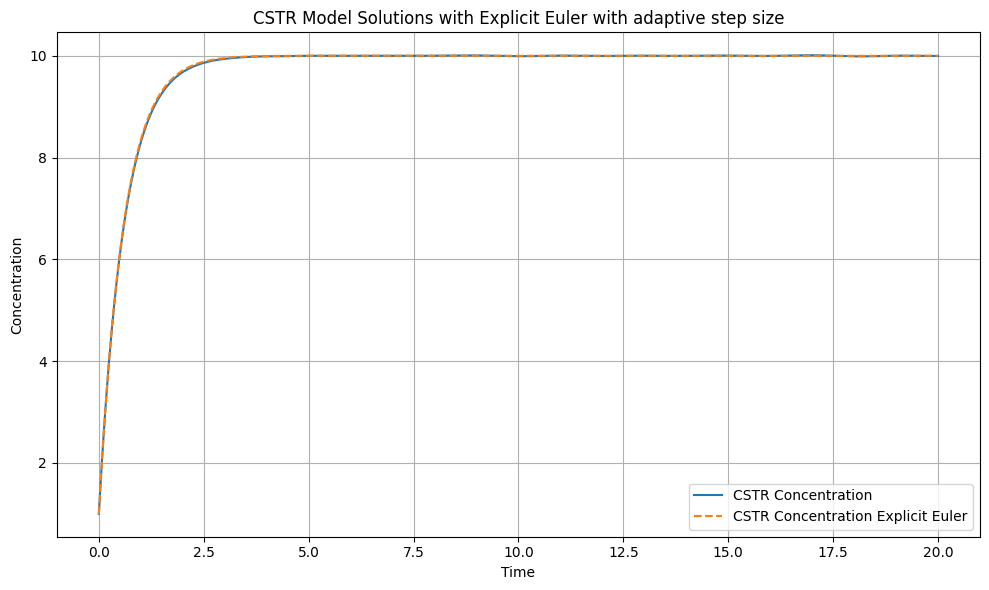

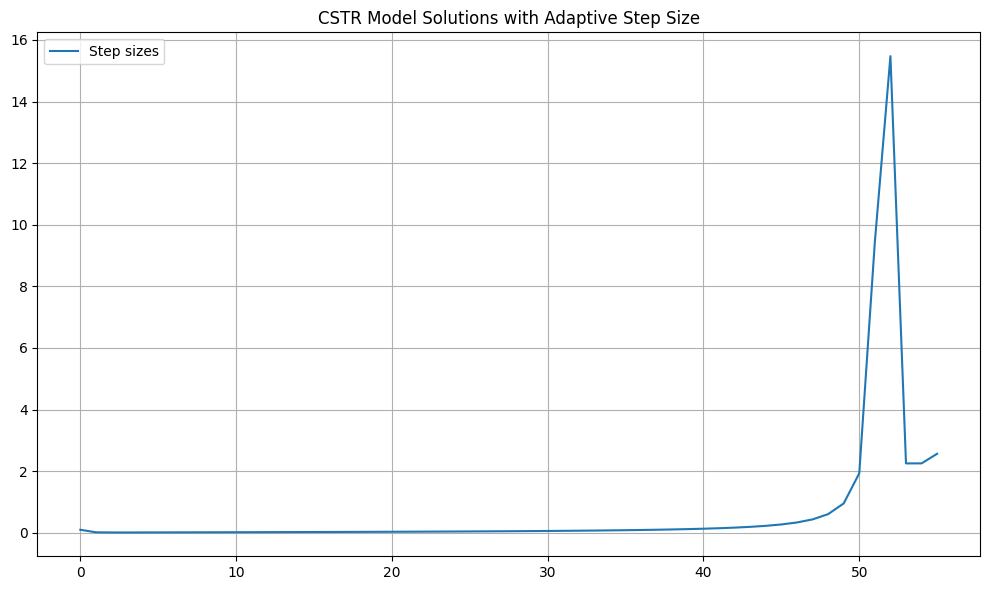

In [75]:
#Solver parameters
h0 = 0.1

abs_tol = 1e-3
rel_tol = 1e-3

solution_adaptive_t, solution_adaptive_x, solution_adaptive_h = ExplicitEulerAdaptiveStep(f, t_span, x0, h0, abs_tol, rel_tol)

#Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='CSTR Concentration')
plt.plot(solution_adaptive_t, solution_adaptive_x[:,0], label='CSTR Concentration Explicit Euler', linestyle='--')
plt.title('CSTR Model Solutions with Explicit Euler with adaptive step size')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
#Plot the stepsizes in solution_adaptive_h
plt.figure(figsize=(10, 6))
plt.plot(solution_adaptive_h, label = 'Step sizes')
plt.title('CSTR Model Solutions with Adaptive Step Size')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()